# Analysis of RH4 dataset from Talus

In [2]:
import MScausality.data_analysis.gene_set as gs
import MScausality.data_analysis.normalization as norm
from MScausality.graph_construction.indra_networks import analysis_uniprot
from MScausality.graph_construction.graph import GraphBuilder
from MScausality.graph_construction.root_node import build_root_network
from MScausality.causal_model.LVM import LVM

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn import linear_model

import pyro

from indra_cogex.client import Neo4jClient
from y0.dsl import Variable, P
from y0.algorithm.identify import Identification, identify

import os
from dotenv import load_dotenv 
load_dotenv()


# from indra_cogex.client import Neo4jClient
pd.set_option('display.max_rows', 100)
%matplotlib inline

/root/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [35]:
msstats_data_all = pd.read_csv("../../data/rh4/ProteinLevelData_no_missing.csv")
msstats_data = msstats_data_all[msstats_data_all["GROUP"] != "RH4nuclei"]

In [37]:
len(msstats_data["originalRUN"].unique())

180

In [38]:
msstats_model = pd.read_csv("../../data/rh4/model.csv")
# msstats_model = gs.parse_protein_name(msstats_model, column_name ="Protein", parse_gene=True)

In [39]:
msstats_model["Label"].unique()

array(['RH4nuclei-DMSO', 'TAL1699-DMSO', 'TAL1700-DMSO', 'TAL1701-DMSO',
       'TAL1702-DMSO', 'TAL1703-DMSO', 'TAL1704-DMSO', 'TAL1705-DMSO',
       'TAL1706-DMSO', 'TAL1707-DMSO', 'TAL1708-DMSO', 'TAL1710-DMSO',
       'TAL1711-DMSO', 'TAL1713-DMSO', 'TAL1717-DMSO', 'TAL1718-DMSO',
       'TAL1719-DMSO', 'TAL1720-DMSO', 'TAL48-DMSO', 'TAL75-DMSO',
       'TAL87-DMSO'], dtype=object)

In [40]:
msstats_model.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,1433B_HUMAN,RH4nuclei-DMSO,0.100926,0.100699,1.002253,164.0,0.317698,0.381238,NaN,0.047222,0.047222
1,1433B_HUMAN,TAL1699-DMSO,0.011975,0.091925,0.130270,164.0,0.896512,0.999795,NaN,0.040000,0.040000
2,1433B_HUMAN,TAL1700-DMSO,0.023285,0.091925,0.253307,164.0,0.800348,0.999125,NaN,0.047500,0.047500
3,1433B_HUMAN,TAL1701-DMSO,0.068505,0.082220,0.833188,164.0,0.405951,0.997044,NaN,0.047917,0.047917
4,1433B_HUMAN,TAL1702-DMSO,-0.020050,0.091925,-0.218114,164.0,0.827611,0.998716,NaN,0.042500,0.042500


In [41]:
msstats_model[(msstats_model["adj.pvalue"] < .05) & (np.isfinite(msstats_model["log2FC"]))].groupby("Label").size()

Label
RH4nuclei-DMSO    4037
TAL1700-DMSO         1
TAL1701-DMSO         2
TAL1702-DMSO        12
TAL1703-DMSO       976
TAL1706-DMSO         5
TAL1707-DMSO        12
TAL1708-DMSO         3
TAL1711-DMSO       129
TAL1713-DMSO       247
TAL1717-DMSO      1760
TAL48-DMSO          61
TAL75-DMSO           2
TAL87-DMSO         102
dtype: int64

In [42]:
msstats_model[(msstats_model["adj.pvalue"] < .05) & (np.isfinite(msstats_model["log2FC"])) & (msstats_model["Label"] == "RH4nuclei-DMSO")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
105,1433T_HUMAN,RH4nuclei-DMSO,-0.272502,0.098327,-2.771395,164.0,6.226911e-03,1.011830e-02,NaN,0.191667,0.191667
147,2A5D_HUMAN,RH4nuclei-DMSO,-1.409284,0.116753,-12.070608,164.0,0.000000e+00,0.000000e+00,NaN,0.188889,0.188889
168,2A5E_HUMAN,RH4nuclei-DMSO,-0.390261,0.145715,-2.678252,164.0,8.154159e-03,1.302720e-02,NaN,0.180556,0.180556
189,2A5G_HUMAN,RH4nuclei-DMSO,-0.436037,0.071030,-6.138745,164.0,6.046273e-09,1.631912e-08,NaN,0.052778,0.052778
210,2AAA_HUMAN,RH4nuclei-DMSO,-0.632910,0.062368,-10.148046,164.0,0.000000e+00,0.000000e+00,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
140595,ZSC21_HUMAN,RH4nuclei-DMSO,-1.847340,0.384786,-4.800953,164.0,3.534812e-06,7.812120e-06,NaN,0.330556,0.330556
140700,ZSWM3_HUMAN,RH4nuclei-DMSO,-1.906668,0.605108,-3.150953,148.0,1.969839e-03,3.410606e-03,NaN,0.350000,0.127778
140721,ZSWM6_HUMAN,RH4nuclei-DMSO,-1.185851,0.360567,-3.288855,80.0,1.496706e-03,2.627709e-03,NaN,0.648148,0.148148
140763,ZW10_HUMAN,RH4nuclei-DMSO,-1.245051,0.070096,-17.762200,164.0,0.000000e+00,0.000000e+00,NaN,0.102778,0.102778


## Normalize Data

In [43]:
msstats_data = norm.normalize(msstats_data)

## Find gene sets with high correlation

In [44]:
input_data = gs.prep_msstats_data(msstats_data, gene_map=None, parse_gene=True)
input_data = input_data.reset_index(drop=True)
input_data.columns.name = None
corr_data = gs.gen_correlation_matrix(input_data, methods=["pearson"], abs_corr=True)

Correlation matrix for pearson:


<Axes: >

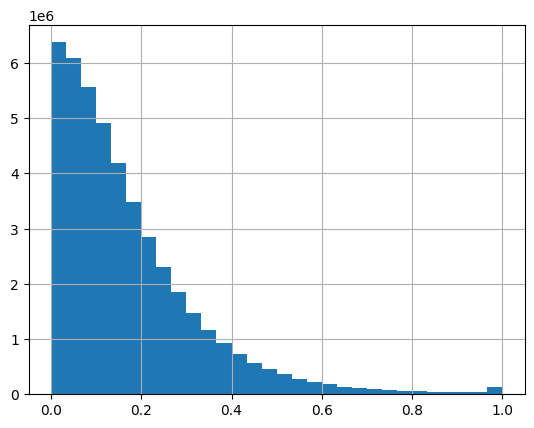

In [45]:
corr_data["pearson"]["value"].hist(bins=30)

### Regulatory pathways

In [46]:
regulatory_paths = gs.test_gene_sets(corr_data, input_data.columns.values, 
                                     "../../data/gene_sets/regulatory_pathways.json", 
                                     threshold=0.33, 
                                     differential_analysis=msstats_model[(msstats_model["DF"] > 30) & \
                                                                         (np.isfinite(msstats_model["log2FC"]))],
                                     comparison="DMSO-DbET6", fc_pval="fc", cutoff=.5)
regulatory_paths

AAANWWTGC_UNKNOWN
AAAYRNCTG_UNKNOWN
AAAYWAACM_HFH4_01
AACTTT_UNKNOWN
AACWWCAANK_UNKNOWN
AACYNNNNTTCCS_UNKNOWN
AAGWWRNYGGC_UNKNOWN
ACAWNRNSRCGG_UNKNOWN
ACAWYAAAG_UNKNOWN
ACCTGTTG_UNKNOWN
ACTAYRNNNCCCR_UNKNOWN
ACTWSNACTNY_UNKNOWN
ADA2_TARGET_GENES
ADCYAP1_TARGET_GENES
ADNP_TARGET_GENES
AEBP2_TARGET_GENES
AFP1_Q6
AGCYRWTTC_UNKNOWN
AHR_01
AHR_Q5
AHRARNT_01
AHRARNT_02
AHRR_TARGET_GENES
ALKBH3_TARGET_GENES
ALPHACP1_01
ALX4_01
ALX4_TARGET_GENES
AMEF2_Q6
AML1_01
AML1_Q6
AML_Q6
AP1_01
AP1_C
AP1_Q2
AP1_Q2_01
AP1_Q4
AP1_Q4_01
AP1_Q6
AP1_Q6_01
AP1FJ_Q2
AP2_Q3
AP2_Q6
AP2_Q6_01
AP2ALPHA_01
AP2GAMMA_01
AP2REP_01
AP3_Q6
AP4_01
AP4_Q5
AP4_Q6
AP4_Q6_01
AR_01
AR_02
AR_03
AR_Q2
AR_Q6
AREB6_01
AREB6_02
AREB6_03
AREB6_04
ARGGGTTAA_UNKNOWN
ARHGAP35_TARGET_GENES
ARID3B_TARGET_GENES
ARID5B_TARGET_GENES
ARNT2_TARGET_GENES
ARNT_01
ARNT_02
ARP1_01
ASH1L_TARGET_GENES
ASXL2_TARGET_GENES
ATCMNTCCGY_UNKNOWN
ATF1_Q6
ATF3_Q6
ATF4_Q2
ATF5_TARGET_GENES
ATF6_01
ATF6_TARGET_GENES
ATF_01
ATF_B
ATGGYGGA_UNKNOWN
ATM_TARGET_GE

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent,freq_node_percent,differential_percent
0,AAANWWTGC_UNKNOWN,pearson,195,44,0.225641,946,64,0.067653,0.333333,0.0
1,AAAYRNCTG_UNKNOWN,pearson,375,82,0.218667,3321,433,0.130382,0.362500,0.0
2,AAAYWAACM_HFH4_01,pearson,262,54,0.206107,1431,174,0.121593,0.370370,0.0
3,AACTTT_UNKNOWN,pearson,1928,428,0.221992,91378,9640,0.105496,0.408879,0.0
4,AACWWCAANK_UNKNOWN,pearson,146,43,0.294521,903,108,0.119601,0.450000,0.0
...,...,...,...,...,...,...,...,...,...,...
1110,ZSCAN4_TARGET_GENES,pearson,1458,266,0.182442,35245,4033,0.114428,0.437736,0.0
1111,ZSCAN5B_TARGET_GENES,pearson,85,11,0.129412,55,5,0.090909,0.166667,0.0
1112,ZSCAN5C_TARGET_GENES,pearson,152,40,0.263158,780,80,0.102564,0.400000,0.0
1113,ZSCAN5DP_TARGET_GENES,pearson,1533,383,0.249837,73153,10162,0.138914,0.420366,0.0


In [47]:
regulatory_paths.to_csv("../../data/rh4/regulatory_paths_rh4_corr.csv")
# regulatory_paths = pd.read_csv("../../data/rh4/regulatory_paths_rh4_corr.csv")

In [23]:
regulatory_paths[(regulatory_paths["measured_genes"] < 20) & (regulatory_paths["percent"] > .5)]

,Unnamed: 0,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent,freq_node_percent,differential_percent
52,52,AR_02,pearson,40,8,0.200000,28,15,0.535714,0.571429,0.0
105,105,CARM1_TARGET_GENES,pearson,13,5,0.384615,10,7,0.700000,0.200000,0.0
118,118,CCAWWNAAGG_SRF_Q4,pearson,88,19,0.215909,171,88,0.514620,0.526316,0.0
131,131,CDPCR3_01,pearson,57,7,0.122807,21,11,0.523810,0.428571,0.0
147,147,CENPT_TARGET_GENES,pearson,85,11,0.129412,55,28,0.509091,0.454545,0.0
191,191,CTR9_TARGET_GENES,pearson,68,16,0.235294,120,63,0.525000,0.500000,0.0
211,211,DROSHA_TARGET_GENES,pearson,69,7,0.101449,21,11,0.523810,0.285714,0.0
260,260,ERCC8_TARGET_GENES,pearson,16,4,0.250000,6,4,0.666667,0.250000,0.0
297,297,FOXQ1_TARGET_GENES,pearson,39,13,0.333333,78,47,0.602564,0.461538,0.0
343,343,GKCGCNNNNNNNTGAYG_UNKNOWN,pearson,60,19,0.316667,171,107,0.625731,0.526316,0.0


In [25]:
CDPCR3 = gs.extract_genes_in_path(input_data.columns, "CDPCR3_01", 
                         "../../data/gene_sets/regulatory_pathways.json", 
                         return_all=False)

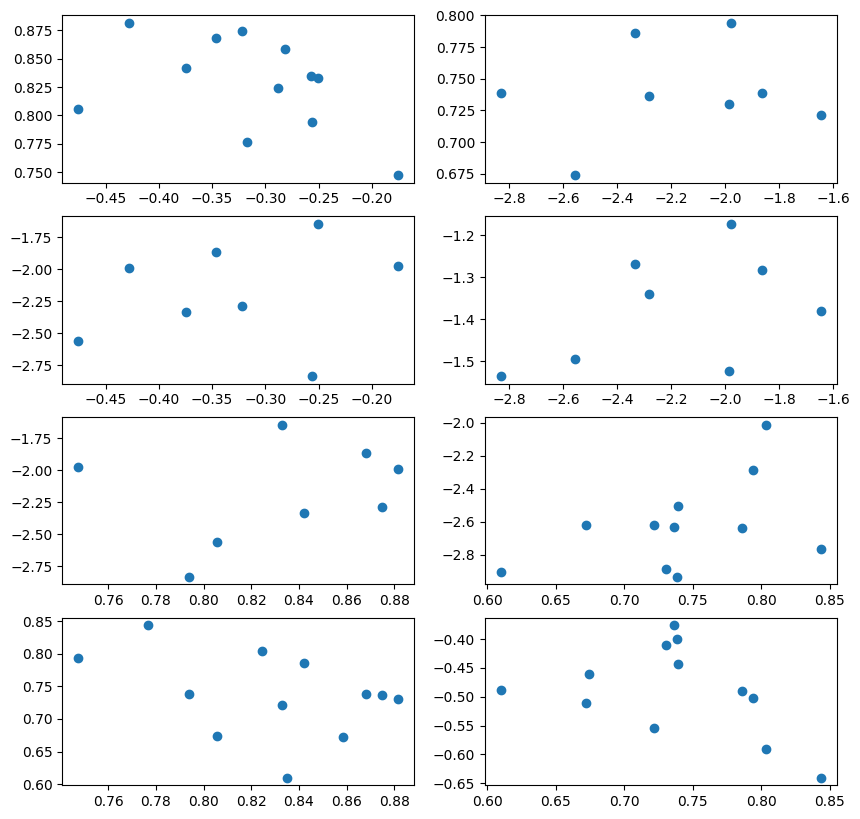

In [32]:
fig, ax = plt.subplots(4,2, figsize=(10,10)) 

ax[0,0].scatter(input_data.loc[:, CDPCR3[0]], input_data.loc[:, CDPCR3[1]])
ax[1,0].scatter(input_data.loc[:, CDPCR3[0]], input_data.loc[:, CDPCR3[2]])

ax[2,0].scatter(input_data.loc[:, CDPCR3[1]], input_data.loc[:, CDPCR3[2]])
ax[3,0].scatter(input_data.loc[:, CDPCR3[1]], input_data.loc[:, CDPCR3[3]])

ax[0,1].scatter(input_data.loc[:, CDPCR3[2]], input_data.loc[:, CDPCR3[3]])
ax[1,1].scatter(input_data.loc[:, CDPCR3[2]], input_data.loc[:, CDPCR3[4]])

ax[2,1].scatter(input_data.loc[:, CDPCR3[3]], input_data.loc[:, CDPCR3[5]])
ax[3,1].scatter(input_data.loc[:, CDPCR3[3]], input_data.loc[:, CDPCR3[6]])

### Hallmark pathways

In [17]:
hallmark_paths = gs.test_gene_sets(corr_data, input_data.columns.values, 
                                   "../../data/gene_sets/hallmark_pathways.json", 
                                     threshold=0.33, 
                                     differential_analysis=msstats_model[(msstats_model["DF"] > 30) & \
                                                                         (np.isfinite(msstats_model["log2FC"]))],
                                     comparison="DMSO-DbET6", fc_pval="fc", cutoff=.5)
hallmark_paths.to_csv("../../data/rh4/hallmark_paths_rh4_corr.csv")

HALLMARK_ADIPOGENESIS
HALLMARK_ALLOGRAFT_REJECTION
HALLMARK_ANDROGEN_RESPONSE
HALLMARK_ANGIOGENESIS
HALLMARK_APICAL_JUNCTION
HALLMARK_APICAL_SURFACE
HALLMARK_APOPTOSIS
HALLMARK_BILE_ACID_METABOLISM
HALLMARK_CHOLESTEROL_HOMEOSTASIS
HALLMARK_COAGULATION
HALLMARK_COMPLEMENT
HALLMARK_DNA_REPAIR
HALLMARK_E2F_TARGETS
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
HALLMARK_ESTROGEN_RESPONSE_EARLY
HALLMARK_ESTROGEN_RESPONSE_LATE
HALLMARK_FATTY_ACID_METABOLISM
HALLMARK_G2M_CHECKPOINT
HALLMARK_GLYCOLYSIS
HALLMARK_HEDGEHOG_SIGNALING
HALLMARK_HEME_METABOLISM
HALLMARK_HYPOXIA
HALLMARK_IL2_STAT5_SIGNALING
HALLMARK_IL6_JAK_STAT3_SIGNALING
HALLMARK_INFLAMMATORY_RESPONSE
HALLMARK_INTERFERON_ALPHA_RESPONSE
HALLMARK_INTERFERON_GAMMA_RESPONSE
HALLMARK_KRAS_SIGNALING_DN
HALLMARK_KRAS_SIGNALING_UP
HALLMARK_MITOTIC_SPINDLE
HALLMARK_MTORC1_SIGNALING
HALLMARK_MYC_TARGETS_V1
HALLMARK_MYC_TARGETS_V2
HALLMARK_MYOGENESIS
HALLMARK_NOTCH_SIGNALING
HALLMARK_OXIDATIVE_PHOSPHORYLATION
HALLMARK_P53_PATHWAY
HALLMARK_PANCREAS

### Cancer pathways

In [11]:
cancer_paths = gs.test_gene_sets(corr_data, input_data.columns.values, 
                                 "../../data/gene_sets/cancer_pathways.json", 
                                 threshold=0.33,
                                 differential_analysis=msstats_model[(msstats_model["DF"] > 30) & \
                                                                         (np.isfinite(msstats_model["log2FC"]))],
                                comparison="DMSO-DbET6", fc_pval="fc", cutoff=.5)
cancer_paths.to_csv("../../data/rh4/cancer_paths_rh4_corr.csv", index=False)

GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M
GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S
GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH
GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN
GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS
GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA
GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO
GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION
GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE
GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION
GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION
GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1
GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2
GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3
GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4
GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA
GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1
GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2
GAVISH_3CA_MALIGNANT_METAPROGRAM_19_EPITHELIAL_SENESCENCE
GAVISH_3CA_MALIGNANT_METAPROGRA